# Quantization

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/riccardoberta/machine-learning/blob/master/08-tiny-machine-learning/03-quantization.ipynb)

Running a DNN on edge devices (with low power and limited memory) is often a challenge due to the huge memory requirements to store the input data, weight parameters and activations of the network as well as the massive amount of computations required for the calculation of the weighted sums of the neurons inputs. 

To tackle this problem, a possible solution is to perform **Quantization** ([B. Jacob, S. Kligys, B. Chen, M. Zhu, M. Tang, A. Howard, H. Adam, and D. Kalenichenko, "Quantization and Training of Neural Networks for Efficient Integer-Arithmetic-Only Inference"](https://arxiv.org/abs/1712.05877)). It isn't something new, it has been around for many years and have been extensively since the creation of digital electronics. In digital signal processing, quantization usually refers to converting continuous signal (like light or sound) into discrete digital number. In deep learning, quantization means converting signed single precision floating point (float32) to lower precision number format such as unsigned 8-bit integer (uint8).  Although quantization can reduce memory, it is not mainly to save storage but rather to speed up the inference. This can happen for two reasons: deep neural networks have a lot of parameters (weights) and loading them from memory can become the bottleneck rather than the actual computation, so is moving the activations back the the main memor; fixed point computation is usually faster than the floating point counterpart. 

Quantization mapping
1. [Quantization mapping](#Quantization-mapping) 
2. [Quantized Matrix Multiplication](#Quantized-Matrix-Multiplication) 
3. [Quantized Deep Learning Layers](#Quantized-Deep-Learning-Layers) 
4. [Neural Networks Integer Quantization Modes](#Neural-Networks-Integer-Quantization-Modes) 

## Quantization mapping

Quantization maps a floating point value $x \in [\alpha, \beta]$ t a b-bit integer  $x_q \in [\alpha_q, \beta_q]$. Mathematically, the quantization process is defined as:

$\begin{align}
x_q = \text{round}(\frac{x}{c} - d)
\end{align}$

and the de-quantization process is defined as:

$\begin{align}
x = c(x_q + d)
\end{align}$

where $c$ and $d$ are parameters which can be derived in order to assure that $\alpha_q$ maps to $\alpha$ and $\beta_q$ maps to $\beta$. 

<img src="./images/quantization-mapping.png" width="500"> 

So we would just have to solve a linear system:

$\begin{align}
\alpha = c(\alpha_q + d)
\end{align}$

$\begin{align}
\beta = c(\beta_q + d)
\end{align}$

The solution is:

$\begin{align}
c = \frac{\beta - \alpha}{\beta_q - \alpha_q}
\end{align}$

$\begin{align}
d = \frac{\alpha \beta_q - \beta \alpha_q}{\beta - \alpha}
\end{align}$

In practice, we would have to ensure that 0 in floating point is represented exactly with no error after quantization. Mathematichally, we need to ensure:

$\begin{align}
x_q = \text{round}(\frac{0}{c} - d) = -\text{round}(d)
\end{align}$

This means that:

$\begin{align}
d = \text{round}(d) = \text{round}(\frac{\alpha \beta_q - \beta \alpha_q}{\beta - \alpha})
\end{align}$

By convention, we denote $c$ as the **scale** $s$ and $−d$ as the **zero point** z. To summarize, the quantization and de-quantization processes are defined as:

$\begin{align}
x_q = \text{round}(\frac{x}{s} + z)
\end{align}$

$\begin{align}
x = s(x_q - z)
\end{align}$

$\begin{align}
s = \frac{\beta - \alpha}{\beta_q - \alpha_q}
\end{align}$

$\begin{align}
z = \text{round}(\frac{\beta \alpha_q - \alpha \beta_q }{\beta - \alpha})
\end{align}$

If the integer type is **signed INTb** then:

$\begin{align}
(\alpha_q, \beta_q) = (-2^{b-1}, 2^{b-1}-1)
\end{align}$

Else, if the integer type is **unsigned UINTb** then:

$\begin{align}
(\alpha_q, \beta_q) = (0, 2^b-1)
\end{align}$

In practice, the quantization process will have chance to have $x$ that is outside the range of $[\alpha, \beta]$, thus the quantized value $x_q$  will also be outside the range of $[\alpha_q, \beta_q]$ and we need to clip the values that are outside the range. More concretely, the quantization process will have an additional clip step: 

$\begin{align}
x_q = \text{clip}(\text{round}(\frac{x}{s} + z), \alpha_q, \beta_q)
\end{align}$

There are other ways of quantization mapping, potentially even non-linear.

In [3]:
import numpy as np

def quantization(x, s, z, alpha_q=-128, beta_q=127):
    x_q = np.round(1 / s * x + z, decimals=0)
    x_q = np.clip(x_q, a_min=alpha_q, a_max=beta_q)
    return x_q

def dequantization(x_q, s, z):
    x = s * (x_q - z)
    x = x.astype(np.float32)
    return x

def generate_quantization_constants(alpha, beta, alpha_q=-128, beta_q=127):
    s = (beta - alpha) / (beta_q - alpha_q)
    z = int((beta * alpha_q - alpha * beta_q) / (beta - alpha))
    return s, z

In [4]:
alpha = -100
beta = 100

alpha_q = -10
beta_q = 10

s,z = generate_quantization_constants(alpha, beta, alpha_q, beta_q)

x = np.arange (alpha-50, beta+50, 0.1)
x_q = quantization(x, s, z, alpha_q, beta_q)

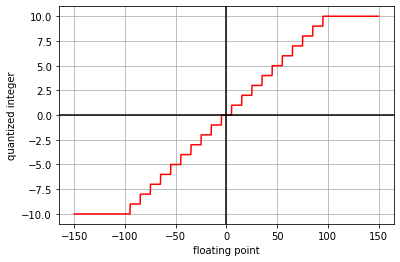

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(x, x_q,color='r')
ax.set_xlabel("floating point")
ax.set_ylabel("quantized integer")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.grid(True)

## Quantized Matrix Multiplication

Suppose we have to perform the tipycal matrix multiplication of a neuron:

$\begin{align}
Y = X W + b
\end{align}$

where $X \in R^{m \times p}$, $W \in R^{p \times n}$ and $b \in R^n$ resulting in $Y \in R^{m \times n}$

We would need to do $p$ floating number multiplications and $p$ floating number additions to compute one single entry in $Y$:

$\begin{align}
Y_{i,j} = b_j + \sum\limits_{k=1}^{p}{X_{i,k}W_{k,j}} 
\end{align}$

To complete the full matrix multiplication, given there are ($m \cdot n$) entries in $Y$, we would need to do ($m \cdot p \cdot n$) floating number multiplications and ($m \cdot p \cdot n$) floating number additions.

Can we complete the same matrix multiplication using quantized values? Here we apply the de-quantization equation:

$\begin{align}
Y_{i,j} = b_j + \sum\limits_{k=1}^{p}{X_{i,k}W_{k,j}}=
\end{align}$

$\begin{align}
= s_b(b_{q,j}-z_b) + \sum\limits_{k=1}^{p}{s_X(X_{q,i,k}-z_X)s_W(W_{q,k,j}-z_W)}=
\end{align}$

$\begin{align}
= s_b(b_{q,j}-z_b) + s_X s_W \sum\limits_{k=1}^{p}{(X_{q,i,k}-z_X)(W_{q,k,j}-z_W)}=
\end{align}$

$\begin{align}
= s_b(b_{q,j}-z_b) + s_X s_W \left[ (\sum\limits_{k=1}^{p}{X_{q,i,k}W_{q,k,j}}) - (z_W \sum\limits_{k=1}^{p}{X_{q,i,k}}) - (z_X \sum\limits_{k=1}^{p}{W_{q,i,k}}) + p z_X z_W \right]
\end{align}$

where $X_q$, $W_q$ and $b_q$ are the quantized matrix for $X$, $W$ and $b$; $s_X$, $s_W$ and $s_b$ are the scales; and $z_X$, $z_W$ and $z_b$ are the zero point.

We can express the operation with quantized matrix $Y_q$:

$\begin{align}
Y_{i,j} = s_Y(Y_{q,i,j}-z_Y)
\end{align}$

therefore,

$\begin{align}
Y_{q,i,j} = z_Y + \frac{s_b}{s_Y}(b_{q,j}-z_b) + \frac{s_X s_W}{s_Y} \left[ (\sum\limits_{k=1}^{p}{X_{q,i,k}W_{q,k,j}}) - (z_W \sum\limits_{k=1}^{p}{X_{q,i,k}}) - (z_X \sum\limits_{k=1}^{p}{W_{q,i,k}}) + p z_X z_W \right]
\end{align}$

Notice that several terms are constant during the inference (don't depend on the particular input) and can be computed offline:

- $z_Y$
- $\frac{s_b}{s_Y}(b_{q,j}-z_b)$
- $z_X \sum\limits_{k=1}^{p}{W_{q,i,k}}$
- $p z_X z_W$

The term

$\begin{align}
\sum\limits_{k=1}^{p}{X_{q,i,k}W_{q,k,j}}
\end{align}$

suggest that we could just do the integer matrix multiplication for $X_q$ and $W_q$. Such integer matrix multiplication could employ special hardware and algorithms, such as [NVIDIA Tensor Core IMMA operations](https://docs.nvidia.com/cuda/ampere-tuning-guide/index.html#tensor-operations), and runs much faster than conventional integer matrix multiplication. Where IMMA stands for **Integer Matrix Multiply and Accumulate** operation.

<img src="./images/tensor-core-operation.png" width="500"> 

The product integer matrix could be converted back to floating point matrix. Suppose that $f_q$ is the quantization function, $f_m$ is the quantized matrix multiplication function and $f_d$ is the de-quantization function, then we can have  a sequence of matrix multiplications whose inputs and outputs are floating point:

$\begin{align}
X_1 = X_0W_0 + b_0
\end{align}$

$\begin{align}
X_2 = X_1W_1 + b_1
\end{align}$

$\begin{align}
...
\end{align}$

$\begin{align}
X_n = X_{n-1}W_{n-1} + b_{n-1}
\end{align}$

We can convert the math using the quatized matrices:

$\begin{align}
X_{0,q} = f_q(X_0, s_{X_0}, z_{X_0})
\end{align}$

$\begin{align}
X_{1,q} = f_m(X_{0,q}, W_{0,q}, b_{0,q})
\end{align}$

$\begin{align}
X_{2,q} = f_m(X_{1,q}, W_{1,q}, b_{1,q})
\end{align}$

$\begin{align}
...
\end{align}$

$\begin{align}
X_{n,q} = f_m(X_{n-1,q}, W_{n-1,q}, b_{n-1,q})
\end{align}$

$\begin{align}
X_n = f_d(X_{n,q}, s_{X_n}, z_{X_n})
\end{align}$

In the following, we implement the quantization matrix multiplication:

In [7]:
def quantization_matrix_multiplication(X_q, W_q, b_q, s_X, z_X, s_W, z_W, s_b, z_b, s_Y, z_Y):
    p = W_q.shape[0]
    Y_q = (z_Y + 
          (s_b / s_Y * (b_q - z_b)).astype(np.int8) +
          ((s_X * s_W / s_Y) * (np.matmul(X_q, W_q) - 
                               z_W * np.sum(X_q, axis=1, keepdims=True) -
                               z_X * np.sum(W_q, axis=0, keepdims=True) +
                               p * z_X * z_W)).astype(np.int8)).astype(np.int8)

    return Y_q

We can make an example comparing the floating point multiplication and the quantized multiplication for some random matices:

In [144]:
m = 2
p = 3
n = 4

# X
alpha_X = -100.0
beta_X = 80.0
X = np.random.uniform(low=alpha_X, high=beta_X, size=(m, p)).astype(np.float32)
s_X, z_X = generate_quantization_constants(alpha=alpha_X, beta=beta_X)
X_q = quantization(x=X, s=s_X, z=z_X)

# W
alpha_W = -20.0
beta_W = 10.0
W = np.random.uniform(low=alpha_W, high=beta_W, size=(p, n)).astype(np.float32)
s_W, z_W = generate_quantization_constants(alpha=alpha_W, beta=beta_W)
W_q = quantization(x=W, s=s_W, z=z_W)

# b
alpha_b = -500.0
beta_b = 500.0
s_b, z_b = generate_quantization_constants(alpha=alpha_b, beta=beta_b)
b = np.random.uniform(low=alpha_b, high=beta_b, size=(1, n)).astype(np.float32)
b_q = quantization(x=b, s=s_b, z=z_b)

# Y
alpha_Y = -3000.0
beta_Y = 3000.0
s_Y, z_Y = generate_quantization_constants(alpha=alpha_Y, beta=beta_Y)
Y = np.matmul(X, W) + b
Y_q_expected = quantization(x=Y, s=s_Y, z=z_Y)

print("Y:")
print(Y)
print("Expected Y_q:")
print(Y_q_expected)

# Quantized Matrix Multiplication 
Y_q_from_multiplication = quantization_matrix_multiplication(X_q, W_q, b_q, s_X, z_X, s_W,z_W,s_b,z_b,s_Y,z_Y)
Y_from_dequantization = dequantization(Y_q_from_multiplication, s_Y, z_Y)

print("Y from Quantized Matrix Multiplication:")
print(Y_q_from_multiplication)
print("Y_q from Quantized Matrix Multiplication:")
print(Y_from_dequantization)

Y:
[[  929.6745     644.75684    125.81782     90.39264 ]
 [-1411.6002   -1204.8408    -716.28015   -106.751465]]
Expected Y_q:
[[ 40.  27.   5.   4.]
 [-60. -51. -30.  -5.]]
Y from Quantized Matrix Multiplication:
[[ 38  27   5   4]
 [-60 -50 -30  -5]]
Y_q from Quantized Matrix Multiplication:
[[  894.1177     635.2941     117.64706     94.117645]
 [-1411.7646   -1176.4706    -705.8823    -117.64706 ]]


Notice that the product FP32 matrix computed using quantized matrices is close to the expectation computed using matrices floating point matrices.

## Quantized Deep Learning Layers

In addition to matrix multiplications, deep learning models also have non-linear activation layers such as ReLU and other special layers such as batch normalization. So the question becomes how do we deal with these layers in a quantized deep learning model in practice?

One trivial solution is to de-quantize the quantized input tensor to these layers, use ordinary floating point computations, and quantize the output tensors. This will work if there are only a few such layers in the model or there is no special implementations to handle these layers in a quantized manner. However, in most of the deep learning models, the number of such layers are not negligible, and using this trivial solution is likely to slow the inference down significantly.

The other solution is to deal with each individual special layers carefully. As an example, we can consider the quantized version of the ReLU activation function.

### Quantized ReLU

We define the activation function ReLU as follows. This might look different from the the conventional ReLU definition, but such definition is more generalized and is convenient for the demonstration of quantized ReLU.

$\begin{align}
\text{ReLU}(x,x_t,y_v,k)= \Big\{ \begin{matrix} y_v  \enspace \enspace \enspace \enspace \enspace \enspace \enspace \enspace \enspace \enspace \text{if} \enspace x \lt x_t \\ y_v + k(x-x_t) \enspace \text{if} \enspace x\geq x_t \end{matrix} 
\end{align}$

The common ReLU is a special case where $x_t=0$, $y_v=0$ and $k=1$

In [152]:
def relu(x, x_t, y_v, k):
    x = np.clip(x, a_min=x_t, a_max=None)
    y = y_v + k * (x - x_t)
    return y

In [153]:
x_t = 0
y_v = 0
k = 1

x = np.arange (-5, 5, 0.1)
y = relu(x, x_t, y_v, k)

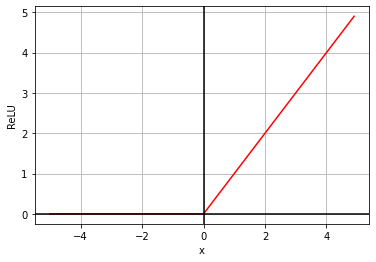

In [154]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(x, y,color='r')
ax.set_xlabel("x")
ax.set_ylabel("ReLU")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.grid(True)

Then let’s derive how the quantized ReLU mathematically:

$\begin{align}
y = \text{ReLU}(x,0,0,1)= \Big\{ \begin{matrix} 0 \enspace \text{if} \enspace x \lt 0 \\ x \enspace \text{if} \enspace x\geq 0 \end{matrix} =
\end{align}$

$\begin{align}
= s_y(y_q - z_y) =
\end{align}$

$\begin{align}
= \text{ReLU}(s_x(x_q-z_x),0,0,1)= \Big\{ \begin{matrix} 0 \enspace \enspace \enspace \enspace \enspace \enspace \enspace \enspace \text{if} \enspace s_x(x_q-z_x) \lt 0 \\ s_x(x_q-z_x) \enspace \text{if} \enspace s_x(x_q-z_x)\geq 0 \end{matrix} =
\end{align}$

$\begin{align}
= \text{ReLU}(s_x(x_q-z_x),0,0,1)= \Big\{ \begin{matrix} 0 \enspace \enspace \enspace \enspace \enspace \enspace \enspace \enspace \text{if} \enspace x_q \lt z_x \\ s_x(x_q-z_x) \enspace \text{if} \enspace x_q \geq z_x \end{matrix}
\end{align}$

therefore,

$\begin{align}
y_q = \text{ReLU}(x_q, z_x, z_y, {s_x}/{s_y})
\end{align}$


So it becomes apparent that to do the quantized ReLU corresponding to the floating point $y = ReLU(x,0,0,1)$, we just have to do $y_q = ReLU(x_q, z_x, z_y,  {s_x}/{s_y})$

In [155]:
def quantization_relu(x_q, s_x, z_x, s_y, z_y):
    y_q = relu(x_q, z_x, z_y, s_x/s_y).astype(np.uint8)
    return y_q

In [156]:
alpha_x = -60.0
beta_x = 60.0
s_x, z_x = generate_quantization_constants(alpha_x, beta_x)
x = np.arange (-5, 5, 0.1)
x_q = quantization(x, s_x, z_x)

alpha_y = -100.0
beta_y = 100.0
s_y, z_y = generate_quantization_constants(alpha_y, beta_y)

y_q = quantization_relu(x_q, s_x, z_x, s_y, z_y)
y = dequantization(y_q, s_y, z_y)

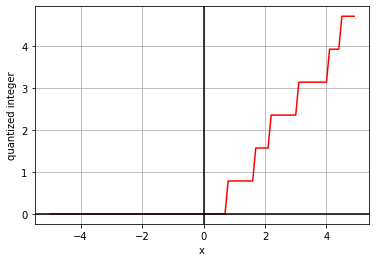

In [157]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(x, y,color='r')
ax.set_xlabel("x")
ax.set_ylabel("Quantized ReLU")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.grid(True)

We can make some simulations:

In [159]:
# Random matrices
m = 2
n = 4

alpha_X = -60.0
beta_X = 60.0
s_X, z_X = generate_quantization_constants(alpha_X, beta_X)
X = np.random.uniform(alpha_X, beta_X, size=(m, n)).astype(np.float32)
X_q = quantization(X, s_X, z_X)

alpha_Y = -100
beta_Y = 100
s_Y, z_Y = generate_quantization_constants(alpha_Y, beta_Y)
Y = relu(X, 0, 0, 1)
Y_q = quantization(Y, s_Y, z_Y)

print("X:")
print(X)
print("X_q:")
print(X_q)

print("Y:")
print(Y)
print("Y_q:")
print(Y_q)

Y_q_from_quantized_ReLU = quantization_relu(X_q,s_X,z_X,s_Y,z_Y)
Y_from_quantized_ReLU = dequantization(Y_q_from_quantized_ReLU, s_Y, z_Y)

print("Y_q from Quantized ReLU:")
print(Y_q_from_quantized_ReLU)
print("Y from Quantized ReLU:")
print(Y_from_quantized_ReLU)

X:
[[ 55.63953   -13.987018   35.007004    3.4673903]
 [  8.165347   51.071598  -51.475674  -49.544483 ]]
X_q:
[[ 118.  -30.   74.    7.]
 [  17.  109. -109. -105.]]
Y:
[[55.63953    0.        35.007004   3.4673903]
 [ 8.165347  51.071598   0.         0.       ]]
Y_q:
[[71.  0. 45.  4.]
 [10. 65.  0.  0.]]
Y_q from Quantized ReLU:
[[70  0 44  4]
 [10 65  0  0]]
Y from Quantized ReLU:
[[54.901962   0.        34.509804   3.137255 ]
 [ 7.8431373 50.980392   0.         0.       ]]


Notice that the FP32 ReLU activations computed using quantized matrices is close to the one computed using floating point matrices.

## Neural Networks Integer Quantization Modes

There are generally two modes for appliyng quantization to neural networks: **post-training quantization** and **quantization aware training**. In order to introduce both of them, we build a Keras Model for MNIST classification and we will use the quantization feature rpovided by [TensorFlow Lite model optimization](https://www.tensorflow.org/lite/performance/model_optimization?hl=en).

In [168]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
import datetime, os

tf.get_logger().setLevel('ERROR')

In [161]:
# Load dataset as train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Preprocess the Data:

In [162]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


Define the model:

In [163]:
from keras.models import Sequential
from keras import models, layers
from keras import regularizers

model = Sequential()
model.add(layers.Dropout(0.2,input_shape=(784,)))
model.add(layers.Dense(1000, kernel_regularizer = regularizers.l2(0.01), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1000, kernel_regularizer = regularizers.l2(0.01), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10,  activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1000)              785000    
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dropout_2 (Dropout)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                10010     
                                                                 
Total params: 1,796,010
Trainable params: 1,796,010
Non-

2022-05-16 14:35:45.678817: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Compile the Keral model:

In [164]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer='adam', 
              metrics=['accuracy'])

Fit the model: 

In [165]:
hist = model.fit(x_train, y_train, batch_size=128,
                 epochs=3, verbose=1,
                 validation_data=(x_test,y_test))


Epoch 1/3
469/469 [==============================] - 11s 22ms/step - loss: 2.0422 - accuracy: 0.8554 - val_loss: 0.7255 - val_accuracy: 0.9006
Epoch 2/3
469/469 [==============================] - 13s 28ms/step - loss: 0.7639 - accuracy: 0.8913 - val_loss: 0.6437 - val_accuracy: 0.9301
Epoch 3/3
469/469 [==============================] - 14s 30ms/step - loss: 0.7281 - accuracy: 0.8979 - val_loss: 0.6140 - val_accuracy: 0.9345


Evaluate the model:

In [166]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss {:.4f}, accuracy {:.2f}%".format(score[0], score[1] * 100))

313/313 [==============================] - 3s 10ms/step - loss: 0.6140 - accuracy: 0.9345
Test loss 0.6140, accuracy 93.45%


### Post-training Quantization

These methods performs quantization on already trained models. We don't need to develop a new model architecture, but we can start with an existing floating point model and quantize it to obtain a fixed point quantized model with almost no accuracy loss, without needing to re-train the model. The **model size reduction** that we can obtain is a **factor of 4**, with negligible accuracy loss.  

We gain also other benefit: reducing the precision at which this data is stored leads to less working memory needed; most processors allow for faster processing of 8-bit data; the reduction in the amount of data movement can have a significant impact also on the power consumption.

All the factors above translate into **faster inference**, with a typical **speedup of 2-3x** due to the reduced precision for both memory accesses and computations. 

The cost is usually o modest decrease in accuracy.

There are some ways in which post-training quantization can be done. 

#### Dynamic Range Quantization

It is the simplest form of post-training quantization which statically quantizes the weights from floating point to 8-bits of precision and dynamically quantizes the activations at inference. This means that the activations are always stored in float 32, however, they are converted to 8-bit integers while processing and back to floating point after the processing is done. 

Following are the steps to perform post-training quantization on our keras model. First of all, we save the  model into a single HDF5 file which will contain the architecture, weights, training configuration (loss, optimizer) and the state of the optimizer:

In [169]:
#Save the entire model in model.h5 file

model.save("models/model.h5")
print("Saved model to disk")

Saved model to disk


The we can use the TensorFlow Lite converter with and without quantization:

In [170]:
model = tf.keras.models.load_model('models/model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("models/converted_model.tflite", "wb").write(tflite_model)

2022-05-16 14:46:32.020977: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-05-16 14:46:33.903383: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-16 14:46:33.903398: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-16 14:46:33.904016: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/np/rkxq5s9x6lzdnx_24x0j3jx80000gn/T/tmpa8ozc9tm
2022-05-16 14:46:33.905878: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-16 14:46:33.905897: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/np/rkxq5s9x6lzdnx_24x0j3jx80000gn/T/tmpa8ozc9tm
2022-05-16 14:46:33.912657: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-05-16 14:46:

7185856

In [171]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open("models/converted_quant_model.tflite", "wb").write(tflite_quant_model)

2022-05-16 14:46:46.977086: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-16 14:46:46.977101: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-16 14:46:46.977215: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/np/rkxq5s9x6lzdnx_24x0j3jx80000gn/T/tmp5u_qmqe9
2022-05-16 14:46:46.978926: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-16 14:46:46.978937: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/np/rkxq5s9x6lzdnx_24x0j3jx80000gn/T/tmp5u_qmqe9
2022-05-16 14:46:46.985151: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-05-16 14:46:47.026409: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /var/folders/np/rkxq5s9x6lzdnx_24x0j3jx80000gn/T/tmp5u_qmqe9
2022-05-

1804024

We can now evaluate the reduction in size of the model. Notice, it is approximately 4x:

In [172]:
print("Float model in Mb:", os.path.getsize('models/converted_model.tflite') / float(2**20))
print("Quantized model in Mb:", os.path.getsize('models/converted_quant_model.tflite') / float(2**20))
print("Compression ratio:", os.path.getsize('models/converted_model.tflite')/os.path.getsize('models/converted_quant_model.tflite'))

Float model in Mb: 6.85296630859375
Quantized model in Mb: 1.7204513549804688
Compression ratio: 3.98323747355911


We can also evaluate the accuracy of converted model on the same test set:

In [173]:
interpreter = tf.lite.Interpreter(model_path="models/converted_quant_model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
acc=0
for i in range(len(x_test)):
    input_data = x_test[i].reshape(input_shape)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    if(np.argmax(output_data) == np.argmax(y_test[i])):
        acc+=1
acc = acc/len(x_test)
print(acc*100)

93.44


We can decide to quantizes the float32 weights into float16, resulting in 2x size reduction. It is generally used with specialized hardware like GPUs which can directly work with float16, thereby providing some speed-up over float32 operations.

In [174]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

#### Static Quantization

Static quantization pre-computes the scales and zero points for all the activation tensors. Therefore, the overhead of computing the scales and zero points is eliminated. The activation tensors could be stored as integer tensors in the memory without having to be converted from floating point tensors. The way to determine the scales and zero points for all the activation tensors is simple. Given a floating point neural network, we would just have to run the neural network using some representative unlabeled data, collect the distribution statistics for all the activation layers. Then we could use the distribution statistics to compute the scales and zero points using the mathematical equations we have described earlier in the article.

During inference, because all the computations were conducted seamlessly using integer ops, the inference performance is the fastest. The only short-coming is that we have to prepare representative unlabeled data. If the data is not representative, the scales and zero points computed might not reflect the true scenario during inference, and the inference accuracy will be harmed.

In [175]:
mnist_train, _ = tf.keras.datasets.mnist.load_data()
images = tf.cast(mnist_train[0], tf.float32) / 255.0
mnist_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)

def representative_data_gen():
  for input_value in mnist_ds.take(100):
    yield [input_value]

In [176]:
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.representative_dataset = representative_data_gen

### Quantization Aware Training

Quantization introduces information loss and therefore the inference accuracies from the quantized integer models are inevitably lower than that from the floating point models. Such information loss is due to that the floating points after quantization and de-quantization is not exactly recoverable. Mathematically, it means:

$\begin{align}
x = f_d(f_q(x,s_x,z_x),s_x,z_x) + \Delta_x
\end{align}$

If $\Delta_x=0$ the inference accuracies from the quantized integer models would be exactly the same as the inference accuracies from the floating point models. Unfortunately, it is not. The idea of quantization aware training is to ask the neural networks to take the effect of such information loss into account during training. Therefore, during inference, the model will have less sacrifice to the inference accuracies. Therefore, in quantization aware training, we added a quantization and a de-quantization layer for each of the tensors. Mathematically, it means

$\begin{align}
\hat{x} = f_d(f_q(x,s_x,z_x),s_x,z_x) = s_x(\text{clip}(\text{round}(\frac{x}{s_x}+z_x),\alpha_q,\beta_q)-z_x)
\end{align}$

where the scale and zero point could be collected using the same method of static quantization. All the data types for the quantized tensors are still floating point tensors and the training is supposed to be done normally as if the quantization and de-quantization layers were not existed. 

The major problem of quantization aware training is that such quantization and de-quantization layers are not differentiable. In practice, the [straight through estimation (STE)](https://arxiv.org/abs/1308.3432) derivative approximation works well for quantization aware training. Essentially, it treats the quantization and de-quantization function as if it were identity function in the clipping range $[\alpha, \beta]$ and constant function outside the clipping range. Therefore, the resulting derivatives are 1 in the clippings range  and 0 outside the clipping range 
Mathematically, it could be described as:

$\begin{align}
\frac{\partial \hat{x}}{\partial y}= \Bigg\{\begin{matrix} 1 \enspace  \text{if} \enspace \alpha \lt x \lt  \beta  \\ 0 \enspace \enspace \enspace \enspace \enspace \enspace \enspace \text{else} \end{matrix}  
\end{align}$

<img src="./images/quantization-aware-training.png" width="500"> 

Quantization Aware Training typically provides higher accuracies as compared to post-training quantization. 

In [22]:
!pip install --upgrade tensorflow-model-optimization

#### Quantizing the whole model

In [177]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

q_aware_model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer='adam', 
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 784)              3         
 er)                                                             
                                                                 
 quant_dropout (QuantizeWrap  (None, 784)              1         
 perV2)                                                          
                                                                 
 quant_dense (QuantizeWrappe  (None, 1000)             785005    
 rV2)                                                            
                                                                 
 quant_dropout_1 (QuantizeWr  (None, 1000)             1         
 apperV2)                                                        
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 1000)             1

In [178]:
hist = q_aware_model.fit(x_train, y_train, batch_size=128,
                         epochs=3, verbose=1,
                         validation_data=(x_test,y_test))

Epoch 1/3
469/469 [==============================] - 17s 35ms/step - loss: 0.6684 - accuracy: 0.9046 - val_loss: 0.5421 - val_accuracy: 0.9411
Epoch 2/3
469/469 [==============================] - 19s 41ms/step - loss: 0.6532 - accuracy: 0.9067 - val_loss: 0.5504 - val_accuracy: 0.9473
Epoch 3/3
469/469 [==============================] - 20s 43ms/step - loss: 0.6476 - accuracy: 0.9097 - val_loss: 0.5167 - val_accuracy: 0.9501


In [25]:
_, baseline_model_accuracy = model.evaluate(x_test, y_test, verbose=1)

_, q_aware_model_accuracy = q_aware_model.evaluate(x_test, y_test, verbose=1)

print('Baseline test accuracy:', baseline_model_accuracy*100)
print('Quant test accuracy:', q_aware_model_accuracy*100)

313/313 [==============================] - 4s 12ms/step - loss: 0.5365 - accuracy: 0.9492
Baseline test accuracy: 94.56999897956848
Quant test accuracy: 94.91999745368958


#### Quantizing some layers

This second method gives us more granularity in order to avoid quantization of layers that are more important for accuracy (for example, later layers instead of the first layers). In that case we need to annotate the layer we want to quantize:

In [26]:
annotate = tfmot.quantization.keras.quantize_annotate_layer

In [27]:
model_annotated = Sequential()
model_annotated.add(layers.Dropout(0.2,input_shape=(784,)))
model_annotated.add(layers.Dense(1000, kernel_regularizer = regularizers.l2(0.01), activation='relu'))
model_annotated.add(layers.Dropout(0.5))
model_annotated.add(annotate(layers.Dense(1000, kernel_regularizer = regularizers.l2(0.01), activation='relu')))
model_annotated.add(layers.Dropout(0.5))
model_annotated.add(layers.Dense(10,  activation='softmax'))

In [28]:
quant_aware_model_annotated = tfmot.quantization.keras.quantize_apply(model_annotated)
quant_aware_model_annotated.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 1000)              785000    
                                                                 
 quant_dropout_7 (QuantizeWr  (None, 1000)             1         
 apperV2)                                                        
                                                                 
 quant_dense_7 (QuantizeWrap  (None, 1000)             1001005   
 perV2)                                                          
                                                                 
 dropout_8 (Dropout)         (None, 1000)              0         
                                                                 
 dense_8 (Dense)             (None, 10)               

In [29]:
quant_aware_model_annotated.compile(loss=keras.losses.categorical_crossentropy, 
                                    optimizer='adam', 
                                    metrics=['accuracy'])

In [30]:
hist = quant_aware_model_annotated.fit(x_train, y_train, batch_size=128,
                                       epochs=3, verbose=1, validation_data=(x_test,y_test))

Epoch 1/3
469/469 [==============================] - 15s 31ms/step - loss: 2.0390 - accuracy: 0.8561 - val_loss: 0.7057 - val_accuracy: 0.9182
Epoch 2/3
469/469 [==============================] - 16s 33ms/step - loss: 0.7643 - accuracy: 0.8904 - val_loss: 0.6642 - val_accuracy: 0.9252
Epoch 3/3
469/469 [==============================] - 16s 34ms/step - loss: 0.7287 - accuracy: 0.8979 - val_loss: 0.6292 - val_accuracy: 0.9228
